## Data Cleaning and Preprocessing

In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import string
import re
from sklearn.base import BaseEstimator, TransformerMixin

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


In [2]:
# Text cleaner found on github: https://github.com/martinpella/twitter-airlines/blob/master/utils.py
class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bu\b', 'you', text)
        text = re.sub(r'\bhrs\b', 'hours', text)
        text = re.sub(r'\baa\b', 'a', text)
        text = re.sub(r'\bflightr\b', 'flight', text)
        text = re.sub(r'\bur\b', 'your', text)
        text = re.sub(r'\bhr\b', 'hour', text)
        text = re.sub(r'\bthru\b', 'through', text)
        text = re.sub(r'\br\b', 'are', text)
        text = re.sub(r'\bppl\b', 'people', text)
        text = re.sub(r'\btix\b', 'fix', text)
        text = re.sub(r'\bplz\b', 'please', text)
        text = re.sub(r'\bflightd\b', 'flighted', text)
        text = re.sub(r'\btmrw\b', 'tomorrow', text)
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bpls\b', 'please', text)
        text = re.sub(r'\bfyi\b', 'for your information', text)
        
        text = re.sub(r'\bheyyyy\b', 'hey', text)
        text = re.sub(r'\bguyyyys\b', 'guys', text)
        text = re.sub(r'\byall\b', 'you all', text)
        text = re.sub(r'\basap\b', 'as soon as possible', text)
        text = re.sub(r'\bbtw\b', 'by the way', text)
        text = re.sub(r'\bdm\b', 'direct message', text)
        text = re.sub(r'\bcudtomers\b', 'customers', text)
        text = re.sub(r'\bwtf\b', 'what the fuck', text)
        text = re.sub(r'\biphone\b', 'phone', text)
        text = re.sub(r'\bmins\b', 'minutes', text)
        text = re.sub(r'\btv\b', 'television', text)
        text = re.sub(r'\bokay\b', 'ok', text)
        text = re.sub(r'\bfeb\b', 'february', text)
        text = re.sub(r'\byr\b', 'year', text)
        text = re.sub(r'\bshes\b', 'she is', text)
        text = re.sub(r'\bnope\b', 'no', text)
        text = re.sub(r'\bhes\b', 'he is', text)
        text = re.sub(r'\btill\b', 'until', text)
        text = re.sub(r'\bomg\b', 'oh my god', text)
        text = re.sub(r'\btho\b', 'though', text)
        text = re.sub(r'\bnothappy\b', 'not happy', text)
        return re.sub(r'\bthankyou\b', 'thank you', text)
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower).apply(self.fix_words)
        return clean_X

In [3]:
# load the data
relevant_tweets = pd.read_hdf('datasets/relevant_tweets.h5', 'relevant_tweets')
relevant_tweets['classification'] = 'relevant'
relevant_tweets['binary_class'] = np.ones(len(relevant_tweets)).astype(int)
relevant_tweets = relevant_tweets[['classification', 'binary_class', 'text']]
irrelevant_tweets = pd.read_hdf('datasets/not_relevant_tweets.h5', 'not_relevant_tweets')
irrelevant_tweets['classification'] = 'irrelevant'
irrelevant_tweets['binary_class'] = np.zeros(len(irrelevant_tweets)).astype(int)
irrelevant_tweets = irrelevant_tweets[['classification', 'binary_class', 'text']]
df = pd.concat([relevant_tweets, irrelevant_tweets]).reset_index()
df = df.iloc[:, 1:]
df.head()

,classification,binary_class,text
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B..."
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep..."
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep..."
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B..."
4,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B..."


In [4]:
# Clean the text
tc = TextCleaner()
df['cleaned_text'] = tc.transform(df['text'])
df.head()

,classification,binary_class,text,cleaned_text
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...
4,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...


In [5]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

df['tokenized'] = df['cleaned_text'].apply(lambda row: tokenize(row))
df.head()

,classification,binary_class,text,cleaned_text,tokenized
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
4,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."


In [6]:
df = df.drop_duplicates(subset = ['cleaned_text']).reset_index()
df = df.iloc[:, 1:]
print(len(df))
df.head()

62688


,classification,binary_class,text,cleaned_text,tokenized
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...",many us beaches are unsafe for swimming report...,"[many, us, beaches, are, unsafe, for, swimming..."
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...",sun sand and sewage report shows many us beach...,"[sun, sand, and, sewage, report, shows, many, ..."
4,relevant,1,"Thanks, EPA.\n\nSun, Sand And Sewage: Report S...",thanks epa sun sand and sewage report shows ma...,"[thanks, epa, sun, sand, and, sewage, report, ..."


In [7]:
from nltk.corpus import stopwords

In [8]:
import collections
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

df = df[['classification', 'binary_class', 'text', 'tokenized']]
vocab_counter = collections.Counter()

In [9]:
tokens = np.array(df['tokenized']).reshape(-1, 1)
words = []
for i in range(len(tokens)):
    tweet = tokens[i]
    for j in range(len(tweet)):
        new_word = tweet[j]
        words.append(new_word)

print(type(words))
indivs = []
for tweet in range(len(words)):
    t = words[tweet]
    for j in range(len(t)):
        indivs.append(t[j])
indivs[:2]

<class 'list'>


['sun', 'sand']

In [10]:
vocabulary_size = 25000
from collections import Counter

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
vocabulary = [("<UNK>", None)] + Counter(indivs).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in indivs])
print(len(vocabulary))
#print(len(data))

25000


In [11]:
lengths = df['tokenized'].apply(lambda x: len(x))
print(max(lengths), min(lengths), np.mean(lengths))

53 0 13.877185426237876


In [12]:
word_to_id = {w:i for i, w in enumerate(vocabulary[:25000])}

In [13]:
#word_to_id['<UNK>'] = 0
print(type(word_to_id))
word_to_id

<class 'dict'>


{'<UNK>': 0,
 'water': 1,
 'not': 2,
 'flood': 3,
 'flash': 4,
 'like': 5,
 'no': 6,
 'oil': 7,
 'spill': 8,
 'im': 9,
 'people': 10,
 'dont': 11,
 'one': 12,
 'warning': 13,
 'get': 14,
 'know': 15,
 'time': 16,
 'pm': 17,
 'would': 18,
 'contamination': 19,
 'drought': 20,
 'watch': 21,
 'us': 22,
 'see': 23,
 'think': 24,
 'good': 25,
 'even': 26,
 'still': 27,
 'go': 28,
 'well': 29,
 'thats': 30,
 'love': 31,
 'want': 32,
 'county': 33,
 'much': 34,
 'back': 35,
 'could': 36,
 'really': 37,
 'also': 38,
 'make': 39,
 'de': 40,
 'sanitation': 41,
 'algae': 42,
 'got': 43,
 'drinking': 44,
 'going': 45,
 'way': 46,
 'new': 47,
 'cant': 48,
 'right': 49,
 'said': 50,
 'never': 51,
 'waste': 52,
 'today': 53,
 'bloom': 54,
 'say': 55,
 'take': 56,
 'work': 57,
 'day': 58,
 'years': 59,
 'first': 60,
 'youre': 61,
 'please': 62,
 'need': 63,
 'many': 64,
 'via': 65,
 'que': 66,
 'didnt': 67,
 'issued': 68,
 'last': 69,
 'look': 70,
 'life': 71,
 'sewage': 72,
 'july': 73,
 'rain': 74,


In [14]:
# transform token by id
def transform_to_ids(row):
    return [word_to_id[w] if w in word_to_id else word_to_id['<UNK>'] for w in row]


df['token_int'] = df['tokenized'].apply(lambda x: transform_to_ids(x))
df.head()

,classification,binary_class,text,tokenized,token_int
0,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...","[sun, sand, sewage, report, shows, many, us, b...","[871, 1794, 72, 266, 466, 64, 22, 310, 1505, 545]"
1,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...","[many, us, beaches, unsafe, swimming, report, ...","[64, 22, 310, 1505, 545, 266, 466]"
2,relevant,1,"Many U.S. Beaches Are Unsafe For Swimming, Rep...","[many, us, beaches, unsafe, swimming, report, ...","[64, 22, 310, 1505, 545, 266, 0]"
3,relevant,1,"Sun, Sand And Sewage: Report Shows Many U.S. B...","[sun, sand, sewage, report, shows, many, us, b...","[871, 1794, 72, 266, 466, 64, 22, 310, 1505, 5..."
4,relevant,1,"Thanks, EPA.\n\nSun, Sand And Sewage: Report S...","[thanks, epa, sun, sand, sewage, report, shows...","[198, 1201, 871, 1794, 72, 266, 466, 64, 22, 3..."


In [15]:
# set the max_length
max_length = 40

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['token_int'].values, df['binary_class'].values,
                                                   test_size = 0.2, random_state = 42)

In [16]:
# padding our sequences
X_train = pad_sequences(X_train, maxlen = max_length, value = 0)
X_test = pad_sequences(X_test, maxlen = max_length, value = 0)

## Working CNN

``` python
# creating the embedding matrix
embedding_index = {}

trained_embeds = open('my_final_embeddings_tweets.npy', 'rb')
for line in trained_embeds:
    #if 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
trained_embeds.close()
```

In [17]:
# We now create a neural network that applies different filter sizes (2 and 3) 
# to word vectors, then concatenate the outputs and apply a classifier on top on that.
# We make a multi-layered CNN with an embedding layer dimension of 128
reset_graph()

def multilayer_cnn():
    graph_input = Input(shape = (25000, 128))
    
    convolutions = []
    for filter_size in range(2, 4):
        # We will have a number of 128 filters
        # Could try 'Valid' padding
        X = Convolution1D(128, filter_size, padding = 'same', activation = 'relu')(graph_input)
        convolutions.append(X)
        
    graph_output = concatenate(convolutions, axis = 1)
    graph_output = GlobalMaxPooling1D()(graph_output)
    graph = Model(graph_input, graph_output)
    
    model = Sequential([Embedding(25000, 128, input_length = max_length),
                    graph,
                    Dropout(0.5),
                    Dense(32, activation='relu'),
                    Dense(2, activation='softmax')])
    
    model.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
    
    return model

In [18]:
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

estimator = KerasClassifier(build_fn = multilayer_cnn, epochs=25, batch_size = 1024, verbose = 0)
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
#results = cross_val_score(estimator, X_train, y_train, cv = kfold)

In [19]:
results = cross_val_score(estimator, X_train, y_train, cv = kfold)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [20]:
results.mean(), results.std()

(0.9633300246338333, 0.0015915347069486215)

In [21]:
y_train_2 = np_utils.to_categorical(y_train)
#print(y_train)

In [22]:
y_test_2 = np_utils.to_categorical(y_test)
#print(y_test)

In [24]:
# Add checkpoint and use most accurate model from the epochs
# Best model based on maximum accuracy
best_model = ModelCheckpoint('trained_models/best_trained_model.hdf5', monitor = 'val_acc', verbose = 1,
                             save_best_only = True, mode = 'max')
model_to_use = [best_model]

model = multilayer_cnn()
model.fit(X_train, y_train_2, validation_data = (X_test, y_test_2), epochs = 10, batch_size = 1024, callbacks = model_to_use)
predictions = model.predict(X_test)

Train on 50150 samples, validate on 12538 samples
Epoch 1/10
50150/50150 [==============================] - 42s 846us/step - loss: 0.4560 - acc: 0.7893 - val_loss: 0.1215 - val_acc: 0.9651

Epoch 00001: val_acc improved from -inf to 0.96507, saving model to trained_models/best_trained_model.hdf5
Epoch 2/10
50150/50150 [==============================] - 50s 995us/step - loss: 0.0952 - acc: 0.9723 - val_loss: 0.0916 - val_acc: 0.9729

Epoch 00002: val_acc improved from 0.96507 to 0.97288, saving model to trained_models/best_trained_model.hdf5
Epoch 3/10
50150/50150 [==============================] - 53s 1ms/step - loss: 0.0585 - acc: 0.9829 - val_loss: 0.0950 - val_acc: 0.9719

Epoch 00003: val_acc did not improve from 0.97288
Epoch 4/10
50150/50150 [==============================] - 56s 1ms/step - loss: 0.0385 - acc: 0.9895 - val_loss: 0.1055 - val_acc: 0.9708

Epoch 00004: val_acc did not improve from 0.97288
Epoch 5/10
50150/50150 [==============================] - 51s 1ms/step - loss

In [29]:
print(metrics.accuracy_score(y_test, np.argmax(predictions, axis=1)))
print(metrics.classification_report(y_test, np.argmax(predictions, axis=1), target_names = ['Irelevant', 'Relevant']))

0.9672196522571384
              precision    recall  f1-score   support

   Irelevant       0.97      0.98      0.97      7191
    Relevant       0.97      0.96      0.96      5347

    accuracy                           0.97     12538
   macro avg       0.97      0.97      0.97     12538
weighted avg       0.97      0.97      0.97     12538



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


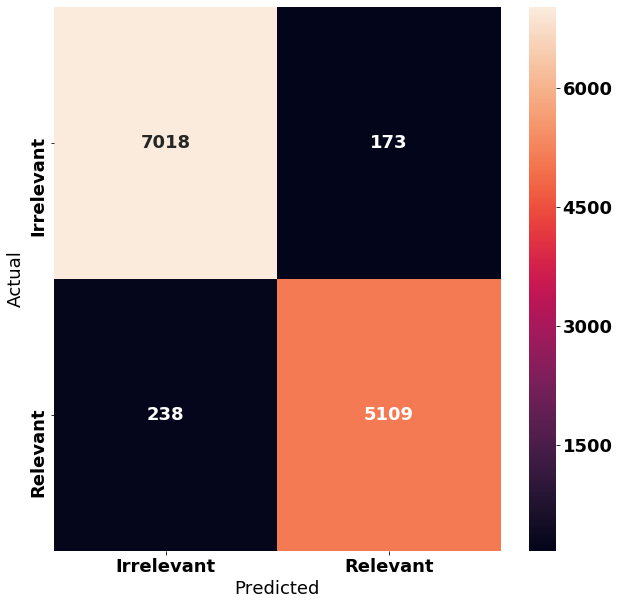

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, np.argmax(predictions, axis = 1))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Irrelevant', 'Relevant'], yticklabels=['Irrelevant', 'Relevant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.show()